In [1]:
import pandas as pd
from database.adatabase import ADatabase
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from tqdm import tqdm
from processor.processor import Processor as p
from asset.exposure import Exposure
from equations.capm import CAPM
from sklearn.preprocessing import normalize
import yfinance as yf

In [2]:
sec = ADatabase("sec")
market = ADatabase("market")
fred = ADatabase("fred")

In [3]:
market.connect()
index = market.retrieve("sp500")
market.disconnect()
factors = ["assets","liabilities","reference_price"]
fred.connect()
sp500 = p.column_date_processing(fred.retrieve("sp500_projections").rename(columns={"prediction":"sp500_prediction"}))
interest_rates = p.column_date_processing(fred.retrieve("market_yield").rename(columns={"value":"rf"}))
interest_rates["rf"] = interest_rates["rf"].replace(".",0)
interest_rates["rf"] = [float(x) / 100 for x in interest_rates["rf"]]
fred.disconnect
macro = sp500.merge(interest_rates,on="date",how="left")

In [4]:
market_data = {}

for ticker in tqdm(index["ticker"]):
    try:
        stock_info = yf.Ticker(ticker).info
        market_data[ticker] = {
            'market_cap': stock_info.get('marketCap', None),
            'sector': stock_info.get('sector', None),
        }
    except KeyError:
        market_data[ticker] = {'market_cap': None, 'sector': None}  # Handle missing data

# Convert to DataFrame
market_caps_df = pd.DataFrame.from_dict(market_data, orient='index').reset_index()
market_caps_df.columns = ['ticker', 'market_cap', 'sector']
print(market_caps_df)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 502/502 [01:40<00:00,  5.02it/s]

    ticker    market_cap             sector
0      MMM  7.089068e+10        Industrials
1      AOS  9.922008e+09        Industrials
2      ABT  1.994456e+11         Healthcare
3     ABBV  3.145686e+11         Healthcare
4      ACN  2.227835e+11         Technology
..     ...           ...                ...
497    XYL  2.855332e+10        Industrials
498    YUM  3.773891e+10  Consumer Cyclical
499   ZBRA  2.006823e+10         Technology
500    ZBH  2.127504e+10         Healthcare
501    ZTS  7.426176e+10         Healthcare

[502 rows x 3 columns]


In [5]:
market.connect()
sec.connect()
factors_df = []
for row in tqdm(index.iterrows()):
    try:
        ticker = row[1]["ticker"]
        cik = int(row[1]["CIK"])
        price = p.column_date_processing(market.query("prices",{"ticker":ticker}))
        price.sort_values("date")
        price["year"] = [x.year for x in price["date"]]
        price["quarter"] = [x.quarter for x in price["date"]]
        filings = p.column_date_processing(sec.query("filings",{"cik":cik}))
        # filings["year"] = [x.year + 1 for x in filings["date"]]
        # filings["quarter"] = [x.quarter for x in filings["date"]]
        filings["year"] = [x.year if x.quarter < 4 else x.year + 1 for x in filings["date"]]
        filings["quarter"] = [x.quarter + 1 if x.quarter < 4 else 1 for x in filings["date"]]
        ticker_factors = filings.drop(["date","cik"],axis=1).groupby(["year","quarter"]).mean().reset_index()
        price = price.drop(["date","ticker"],axis=1).groupby(["year","quarter"]).mean().reset_index()
        ticker_factors = ticker_factors.merge(price,on=["year","quarter"],how="left")
        ticker_factors["ticker"] = ticker
        ticker_factors["reference_price"] = ticker_factors["adjclose"].shift(1)
        ticker_factors["y"] = ticker_factors["adjclose"].shift(-1)
        factors_df.append(ticker_factors[["year","quarter","ticker","adjclose","y"]+factors])
    except Exception as e:
        print(ticker,str(e))
        continue
sec.disconnect()
market.disconnect()
factors_df = pd.concat(factors_df).sort_values(["year","quarter"])

26it [00:01, 21.91it/s]

AMTM 'date'


62it [00:03, 20.80it/s]

BRK.B 'date'


65it [00:03, 20.04it/s]

BLK 'date'


77it [00:04, 20.08it/s]

BF.B 'date'


502it [00:28, 17.87it/s]


ZTS 'date'


In [6]:
model_start = 2013
model_end = 2020
backtest_end = 2025
model = XGBRegressor()
factors_df = factors_df.dropna(subset=factors)
training_data = factors_df[(factors_df["year"]>=model_start) & (factors_df["year"]<model_end)].dropna()
sim = factors_df[(factors_df["year"]>=model_end-1) & (factors_df["year"]<backtest_end)].dropna(subset=factors)
model.fit(training_data[factors],training_data["y"])
sim["prediction"] = model.predict(sim[factors])
sim = sim[["year","quarter","ticker","prediction"]]

In [7]:
market.connect()
prices = []
for ticker in tqdm(index["ticker"]):
    try:
        price = p.column_date_processing(market.query("prices",{"ticker":ticker}))
        price.sort_values("date",inplace=True)
        price["year"] = [x.year for x in price["date"]]
        price["quarter"] = [x.quarter for x in price["date"]]
        price.sort_values("date",inplace=True)
        price = price.merge(sim[["year","quarter","ticker","prediction"]],on=["year","quarter","ticker"],how="left").merge(macro,on="date",how="left")
        price["factor"] = price["prediction"] / price["adjclose"] - 1
        price = CAPM.apply(price)
        prices.append(price)
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

 13%|███████████████████▏                                                                                                                                     | 63/502 [00:03<00:23, 18.57it/s]

'date'


 16%|███████████████████████▊                                                                                                                                 | 78/502 [00:04<00:22, 19.21it/s]

'date'


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 502/502 [00:29<00:00, 16.89it/s]

'date'


In [8]:
simulation = pd.concat(prices).merge(index,on="ticker",how="left").merge(market_caps_df,on="ticker",how="left")
simulation["year"] = simulation["date"].dt.year
simulation["quarter"] = simulation["date"].dt.quarter
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)].dropna()
tickers = list(simulation[simulation["year"]==model_end]["ticker"].unique())
simulation = simulation[simulation["ticker"].isin(tickers)]
simulation["rank"] = simulation.groupby(["date", "GICS Sector"])["factor"].rank(method="dense", ascending=False).astype(int)

# Calculate the total number of ranks for each sector and date
simulation["total_ranks"] = simulation.groupby(["date", "GICS Sector"])["rank"].transform("max")

# Assign exposure based on rank
simulation["exposure"] = simulation.apply(
    lambda x: 1 if x["rank"] <= x["total_ranks"] * 0.50 else -1,
    axis=1
)

# Cleanup: Drop the total_ranks column if not needed
simulation.drop(columns=["total_ranks"], inplace=True)

# Sorting by date for further processing
simulation.sort_values("date", inplace=True)
simulation["sell_price"] = simulation["adjclose"]
simulation["sell_date"] = simulation["date"]
simulation.sort_values("date",inplace=True)

In [9]:
benchmark = macro.copy()
benchmark["year"] = benchmark["date"].dt.year
benchmark["quarter"] = benchmark["date"].dt.quarter
benchmark = benchmark[(benchmark["year"]>=model_end) & (benchmark["year"]<backtest_end)].drop([x for x in benchmark.columns if "real" in x],axis=1).groupby(["year","quarter"]).mean().reset_index()
benchmark["sp500"] = (benchmark["sp500"] - benchmark["sp500"].iloc[0]) /benchmark["sp500"].iloc[0]
benchmark["rf"] = (benchmark["rf"] - benchmark["rf"].iloc[0]) /benchmark["rf"].iloc[0]
benchmark["sp500_prediction"] = (benchmark["sp500_prediction"] - benchmark["sp500_prediction"].iloc[0]) /benchmark["sp500_prediction"].iloc[0]
benchmark.dropna(inplace=True)

In [10]:
def rank_list(value,i):
    # Ensure i is a non-negative integer
    if value == 0:
        if i < 0:
            raise ValueError("The number of integers, i, must be non-negative.")
        
        if i % 2 == 0:
            # Even number of elements: Symmetric around 0
            return list(range(-i // 2, i // 2))
        else:
            # Odd number of elements: Includes 0
            return list(range(-i // 2, i // 2 + 1))
    if value == -1:
        return list(range(-1,-i-1,-1))
    else:
        return list(range(0,i,1))

In [11]:
filtered_columns = ["year","quarter","date","sell_date","GICS Sector","ticker","rank","exposure","adjclose","sell_price"]
agg_query = {"date":"first","sell_date":"last","GICS Sector":"first","exposure":"first","rank":"first","adjclose":"first","sell_price":"last"}

In [12]:
run = True
if run:
    analysises = []
    for direction in tqdm([1,-1]):
        for value in tqdm([1,0,-1]):
            for maximum_index in tqdm([1,50,100,200]):
                for minimum_index in [0,50,100,200]:
                    for num_stocks_per_industry in [1,5,10,25,50]:
                        try:
                            parameters = {
                                "direction":direction,
                                "val":value,
                                "maxi": maximum_index,
                                "mini": minimum_index,
                                "stacks": num_stocks_per_industry
                            }
                            stacks = rank_list(value,num_stocks_per_industry)
                            max_cap = simulation.sort_values("market_cap")["market_cap"].unique()[-maximum_index]
                            min_cap = simulation.sort_values("market_cap")["market_cap"].unique()[minimum_index]
                            filtered_simulation = simulation[(simulation["market_cap"]<=max_cap) & (simulation["market_cap"]>=min_cap)].copy()
                            trades = filtered_simulation[filtered_columns].groupby(["year","quarter","ticker"]).agg(agg_query).reset_index()
                            trades = trades.sort_values("rank",ascending=True).groupby(["year","quarter","GICS Sector"]).nth(stacks).reset_index()
                            trades["return"] = (trades["sell_price"] - trades["adjclose"])/trades["adjclose"]
                            trades["return"] = trades["return"] * trades["exposure"] * direction 
                            analysis = trades[["year","quarter","exposure","return"]].groupby(["year","quarter","exposure"]).mean().pivot_table(index=["year","quarter"],columns="exposure",values="return").reset_index()
                            portfolio = trades[["year","quarter","return"]].groupby(["year","quarter"]).mean().reset_index().sort_values(["year","quarter"])
                            portfolio["return"] = portfolio["return"] + 1
                            portfolio["return"] = portfolio["return"].cumprod() - 1
                            portfolio['Year-Quarter'] = portfolio["year"].astype(str) + "q" + portfolio["quarter"].astype(str)
                            portfolio = portfolio.merge(benchmark,on=["year","quarter"],how="left")
                            portfolio["sharpe"] = portfolio["return"] - portfolio["rf"] / portfolio["return"].std()
                            parameters["risk"] = portfolio["return"].std()
                            parameters["sharpe"] = portfolio["sharpe"].iloc[-1]
                            parameters["return"] = portfolio["return"].iloc[-1]
                            analysises.append(parameters)
                        except Exception as e:
                            print(str(e))
                            continue

  0%|                                                                                                                                                                    | 0/3 [00:00<?, ?it/s]

  0%|                                                                                                                                                                    | 0/4 [00:00<?, ?it/s]

 25%|███████████████████████████████████████                                                                                                                     | 1/4 [00:13<00:41, 13.81s/it]

 50%|██████████████████████████████████████████████████████████████████████████████                                                                              | 2/4 [00:26<00:26, 13.25s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 3/4 [00:38<00:12, 12.58s/it]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:48<00:00, 12.05s/it]

 33%|████████████████████████████████████████████████████                                                                                                        | 1/3 [00:48<01:36, 48.22s/it]

single positional indexer is out-of-bounds




  0%|                                                                                                                                                                    | 0/4 [00:00<?, ?it/s]

 25%|███████████████████████████████████████                                                                                                                     | 1/4 [00:13<00:41, 13.91s/it]

 50%|██████████████████████████████████████████████████████████████████████████████                                                                              | 2/4 [00:26<00:26, 13.26s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 3/4 [00:38<00:12, 12.57s/it]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:48<00:00, 12.07s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 2/3 [01:36<00:48, 48.26s/it]

single positional indexer is out-of-bounds




  0%|                                                                                                                                                                    | 0/4 [00:00<?, ?it/s]

 25%|███████████████████████████████████████                                                                                                                     | 1/4 [00:13<00:41, 13.95s/it]

 50%|██████████████████████████████████████████████████████████████████████████████                                                                              | 2/4 [00:26<00:26, 13.34s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 3/4 [00:38<00:12, 12.61s/it]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:48<00:00, 12.08s/it]

 50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 1/2 [02:24<02:24, 144.83s/it]

single positional indexer is out-of-bounds



  0%|                                                                                                                                                                    | 0/3 [00:00<?, ?it/s]

  0%|                                                                                                                                                                    | 0/4 [00:00<?, ?it/s]

 25%|███████████████████████████████████████                                                                                                                     | 1/4 [00:13<00:41, 13.92s/it]

 50%|██████████████████████████████████████████████████████████████████████████████                                                                              | 2/4 [00:26<00:26, 13.19s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 3/4 [00:38<00:12, 12.49s/it]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:47<00:00, 11.98s/it]

 33%|████████████████████████████████████████████████████                                                                                                        | 1/3 [00:47<01:35, 47.92s/it]

single positional indexer is out-of-bounds




  0%|                                                                                                                                                                    | 0/4 [00:00<?, ?it/s]

 25%|███████████████████████████████████████                                                                                                                     | 1/4 [00:13<00:41, 13.87s/it]

 50%|██████████████████████████████████████████████████████████████████████████████                                                                              | 2/4 [00:26<00:26, 13.26s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 3/4 [00:38<00:12, 12.57s/it]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:48<00:00, 12.06s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 2/3 [01:36<00:48, 48.11s/it]

single positional indexer is out-of-bounds




  0%|                                                                                                                                                                    | 0/4 [00:00<?, ?it/s]

 25%|███████████████████████████████████████                                                                                                                     | 1/4 [00:13<00:41, 13.76s/it]

 50%|██████████████████████████████████████████████████████████████████████████████                                                                              | 2/4 [00:26<00:26, 13.17s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 3/4 [00:38<00:12, 12.48s/it]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:47<00:00, 12.00s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [04:48<00:00, 144.49s/it]

single positional indexer is out-of-bounds


In [13]:
a = pd.DataFrame(analysises)
a["color"] = ["blue" if x == 1 else "red" if x == -1  else "green" for x in a["val"]]
a["return_to_risk"] = a["return"] / a["risk"]

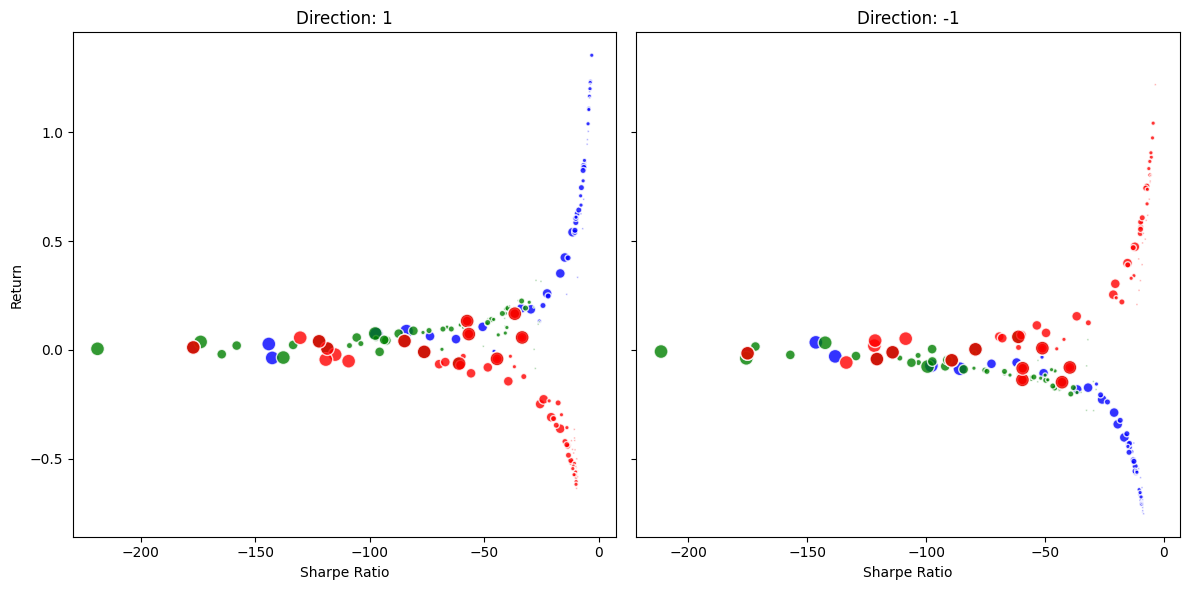

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Direction: 1", "Direction: -1"]

# Iterate over directions and corresponding axes
for i, direction in enumerate([1, -1]):
    d_analysis = a[a["direction"] == direction]
    axes[i].scatter(
        d_analysis["sharpe"],
        d_analysis["return"],
        c=d_analysis["color"],
        s=d_analysis["stacks"] * 2,
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("Sharpe Ratio")
    axes[i].set_ylabel("Return" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [33]:
a.sort_values("return",ascending=False).head(20)

,direction,val,maxi,mini,stacks,risk,sharpe,return,color,return_to_risk
26,1,1,50,50,5,0.432010,-3.024966,1.354426,blue,3.135171
6,1,1,1,50,5,0.392574,-3.584715,1.234612,blue,3.144916
21,1,1,50,0,5,0.384490,-3.691790,1.228866,blue,3.196096
35,1,1,50,200,1,0.383611,-3.710310,1.221613,blue,3.184507
390,-1,-1,1,200,1,0.393712,-3.586260,1.219129,red,3.096496
11,1,1,1,100,5,0.379107,-3.790014,1.200508,blue,3.166672
15,1,1,1,200,1,0.368630,-3.945364,1.186988,blue,3.219996
1,1,1,1,0,5,0.363685,-4.036306,1.165843,blue,3.205643
50,1,1,100,100,1,0.371834,-3.929873,1.158267,blue,3.115016
31,1,1,50,100,5,0.351136,-4.277579,1.110483,blue,3.162545


In [23]:
value = 1
direction = 1
maximum_index = 1
minimum_index = 100
num_stocks_per_industry = 1
stacks = rank_list(value,num_stocks_per_industry)

In [24]:
stacks = rank_list(value,num_stocks_per_industry)
max_cap = simulation.sort_values("market_cap")["market_cap"].unique()[-maximum_index]
min_cap = simulation.sort_values("market_cap")["market_cap"].unique()[minimum_index]
filtered_simulation = simulation[(simulation["market_cap"]<=max_cap) & (simulation["market_cap"]>=min_cap)].copy()
trades = filtered_simulation[filtered_columns].groupby(["year","quarter","ticker"]).agg(agg_query).reset_index()
trades = trades.sort_values("rank",ascending=True).groupby(["year","quarter","GICS Sector"]).nth(stacks).reset_index()
trades["return"] = (trades["sell_price"] - trades["adjclose"])/trades["adjclose"]
trades["return"] = trades["return"] * trades["exposure"] * direction 
analysis = trades[["year","quarter","exposure","return"]].groupby(["year","quarter","exposure"]).mean().pivot_table(index=["year","quarter"],columns="exposure",values="return").reset_index()
portfolio = trades[["year","quarter","return"]].groupby(["year","quarter"]).mean().reset_index().sort_values(["year","quarter"])
portfolio["return"] = portfolio["return"] + 1
portfolio["return"] = portfolio["return"].cumprod() - 1
portfolio['Year-Quarter'] = portfolio["year"].astype(str) + "q" + portfolio["quarter"].astype(str)
portfolio = portfolio.merge(benchmark,on=["year","quarter"],how="left")

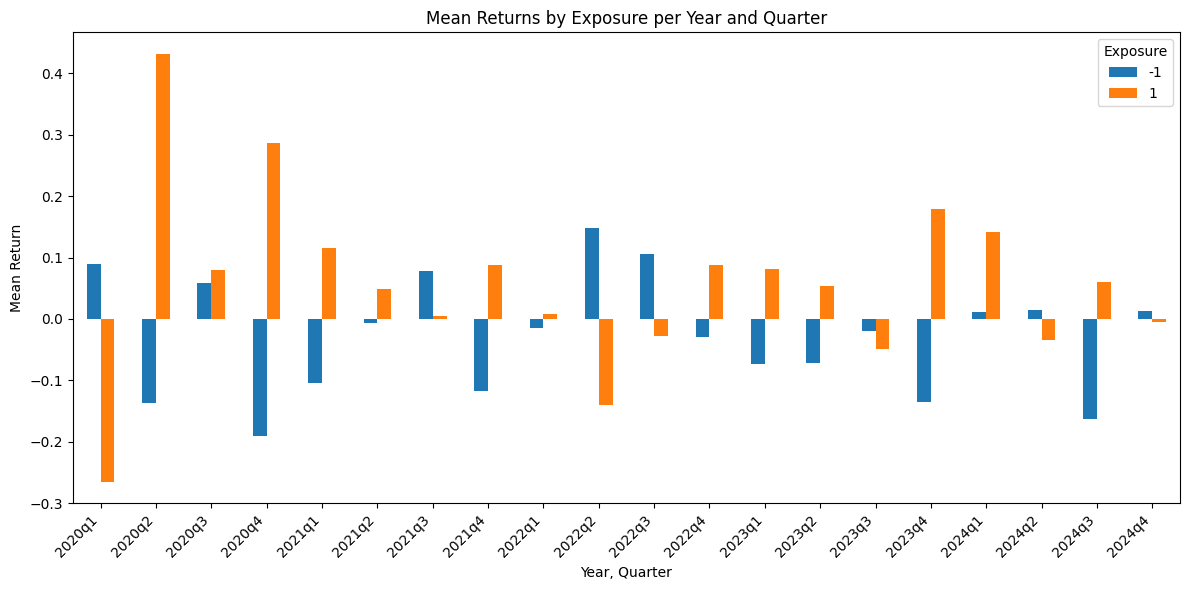

In [25]:
analysis['Year-Quarter'] = analysis["year"].astype(str) + "q" + analysis["quarter"].astype(str)

# Reset index for plotting
analysis.drop(["year","quarter"],axis=1,inplace=True)
analysis.reset_index(drop=True, inplace=True)

# Plot a bar chart
analysis.set_index("Year-Quarter").plot(
    kind="bar",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Customize the plot
plt.xlabel("Year, Quarter")
plt.ylabel("Mean Return")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title="Exposure")
plt.tight_layout()

# Show the plot
plt.show()


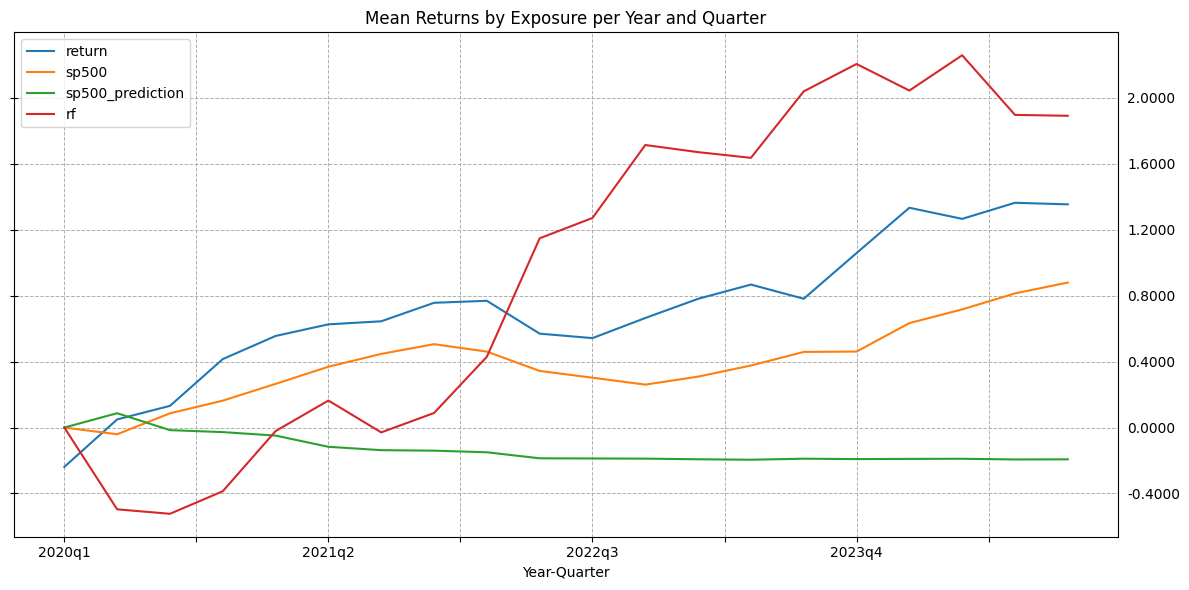

In [26]:
# Create the plot
ax = portfolio.drop(["date", "year", "quarter"], axis=1).set_index("Year-Quarter").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()


In [34]:
portfolio.tail()

,year,quarter,return,Year-Quarter,date,sp500,sp500_prediction,rf
15,2023,4,1.058776,2023q4,2023-11-14 05:42:51.428571392,0.461093,-0.191385,2.206233
16,2024,1,1.333732,2024q1,2024-02-14 09:50:09.836065536,0.633755,-0.190196,2.044977
17,2024,2,1.266338,2024q2,2024-05-14 06:05:42.857142784,0.716902,-0.189471,2.259143
18,2024,3,1.363983,2024q3,2024-08-15 01:52:30.000000000,0.814040,-0.193665,1.897207
19,2024,4,1.354426,2024q4,2024-10-06 02:40:00.000000000,0.879934,-0.192846,1.891941


In [28]:
trades.groupby(["year","quarter","GICS Sector"]).agg({"return":"mean"}).tail(11)

return
year quarter GICS Sector                     
2024 4       Communication Services -0.032650
             Consumer Discretionary  0.013473
             Consumer Staples       -0.024854
             Energy                  0.021873
             Financials              0.007682
             Health Care            -0.042247
             Industrials            -0.007707
             Information Technology  0.048678
             Materials              -0.010731
             Real Estate            -0.027181
             Utilities              -0.002250

In [29]:
print(((macro["sp500"].pct_change().cumsum().iloc[-1]+1) ** (1/6))/macro["sp500"].pct_change().cumsum().std())

4.672939581907131
